# Identify Buildings via object segmentation using SamGeo

This notebook shows how to segment objects from an image. It uses samgeo which uses the Segment Anything Model (SAM). And it requires only a few lines of code.

Make sure you use GPU runtime for this notebook.

- samgeo - https://github.com/opengeos/segment-geospatial
- sam - https://github.com/opengeos/segment-anything

This notebook was adapted from [samgeo/examples/automatic_mask_generator.ipynb](https://github.com/opengeos/segment-geospatial/blob/main/docs/examples/automatic_mask_generator.ipynb]).

## Installation
SageMaker Studio notebook
- Use ml.g4dn.2xlarge instance (1 GPU + 32GB) and a Base Python 3.0 kernel.
- Execute ./setup.sh from the image terminal

In [3]:
import os
import geopandas as gpd
import leafmap.foliumap as leafmap
from samgeo import SamGeo
from samgeo import show_image, download_file, overlay_images, tms_to_geotiff

## Create an interactive map

In [4]:
m = leafmap.Map(center=[37.572465, 36.919509], zoom=17, height="800px")
m.add_basemap("SATELLITE")
m


Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [5]:
bbox = [36.915727, 37.575042, 36.924487, 37.571488]

## Download a sample image

In [6]:
image = "images/city.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=17, source="Satellite", overwrite=True)

Downloaded image 1/8
Downloaded image 2/8
Downloaded image 3/8
Downloaded image 4/8
Downloaded image 5/8
Downloaded image 6/8
Downloaded image 7/8
Downloaded image 8/8
Saving GeoTIFF. Please wait...
Image saved to images/city.tif


Display the downloaded image on the map.

In [7]:
m = leafmap.Map(center=[37.572465, 36.919509], zoom=17, height="800px")
m.add_basemap("SATELLITE", visible=False)
m.add_raster(image, layer_name="Image")
m

## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [8]:
out_dir = os.path.join(os.path.expanduser("~"), "Downloads")
checkpoint = os.path.join(out_dir, "sam_vit_h_4b8939.pth")

In [9]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=None,
)

## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object. 

In [10]:
sam.generate(image, output="output/masks.tif", foreground=True, unique=True)

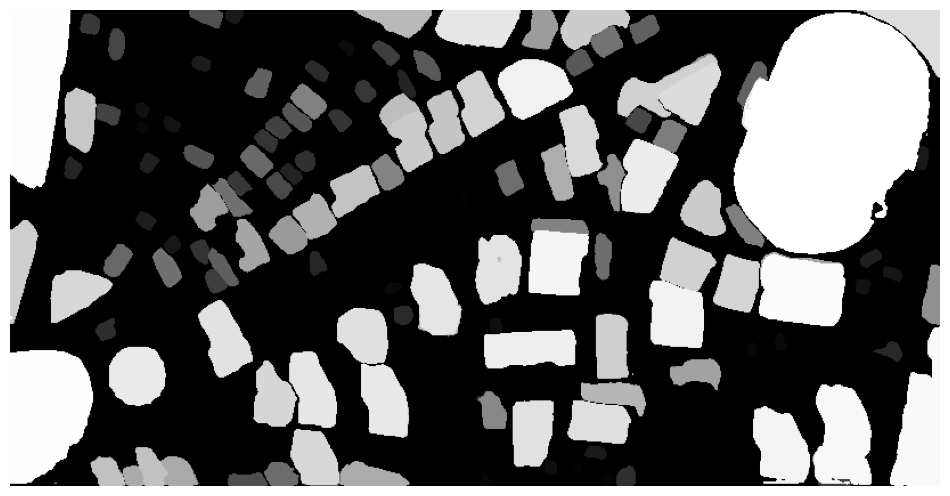

In [11]:
sam.show_masks(cmap="binary_r")

Show the object annotations (objects with random color) on the map.

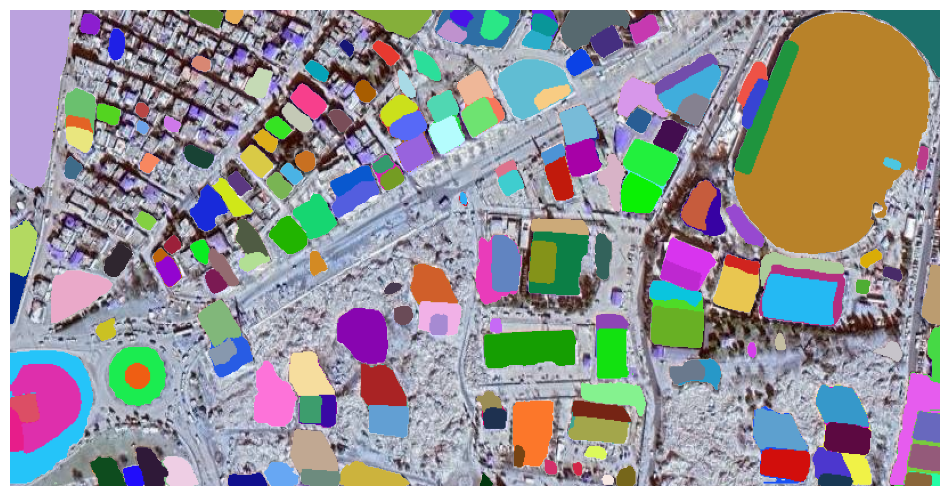

In [12]:
sam.show_anns(axis="off", alpha=1, output="output/annotations.tif")

Compare images with a slider.


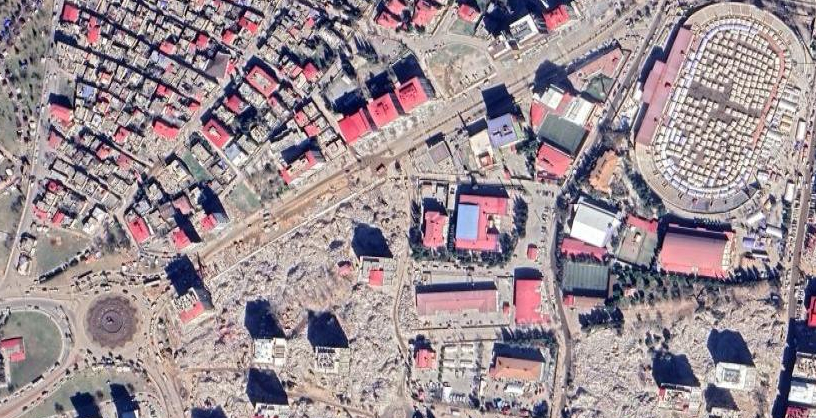
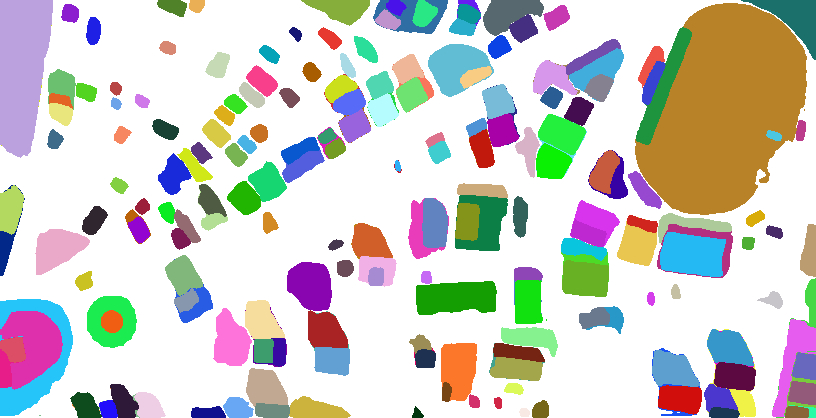

In [13]:
leafmap.image_comparison(
    "images/city.tif",
    "output/annotations.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

Add image to the map.

In [14]:
m.add_raster("output/annotations.tif", alpha=0.5, layer_name="Masks")
m

Convert the object annotations to vector format, such as GeoPackage, Shapefile, or GeoJSON.

In [15]:
sam.tiff_to_shp("output/masks.tif", "output/masks.shp")
sam.tiff_to_geojson("output/masks.tif", "output/masks.geojson")

In [26]:
# Calculate areas
def calc_areas(shpfile):
    data = gpd.read_file(shpfile)
    area =0
    for index, row in data.iterrows():
        geometry = row['geometry']
        if geometry.type == 'Polygon':
            area += geometry.area
    return area

area1 = calc_areas("output/masks.shp")
print(f"Total area: {area1}")

Total area: 208425.1815064465


## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [21]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 100,
}

In [22]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint=checkpoint,
    sam_kwargs=sam_kwargs,
)

In [23]:
sam.generate(image, output="output/masks2.tif", foreground=True)

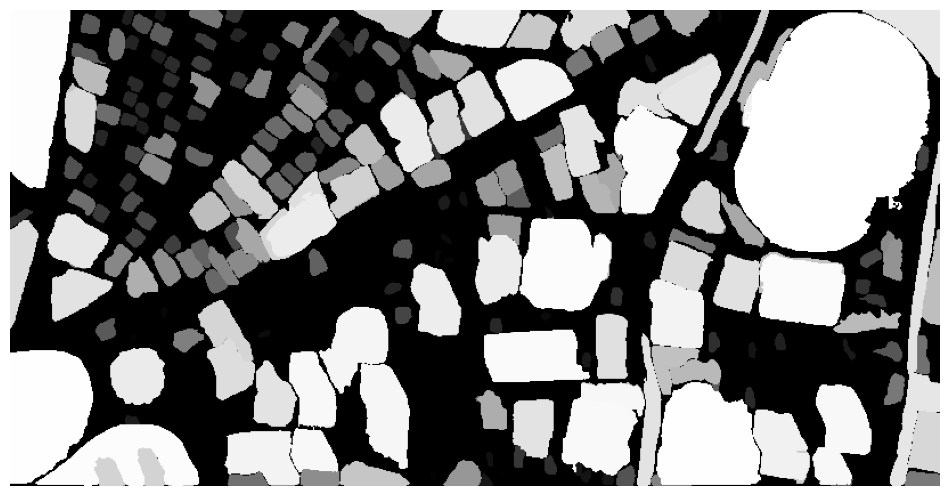

In [24]:
sam.show_masks(cmap="binary_r")

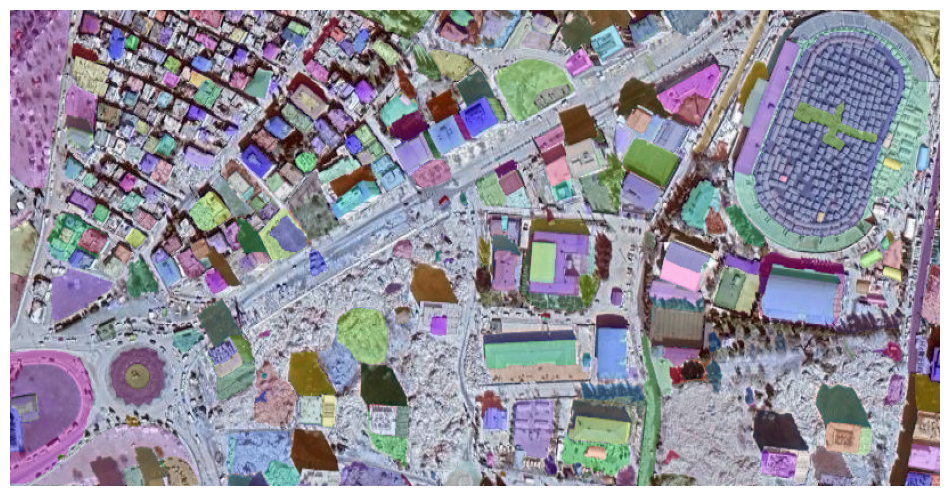

In [25]:
sam.show_anns(axis="off", opacity=1, output="output/annotations2.tif")

Compare images with a slider.


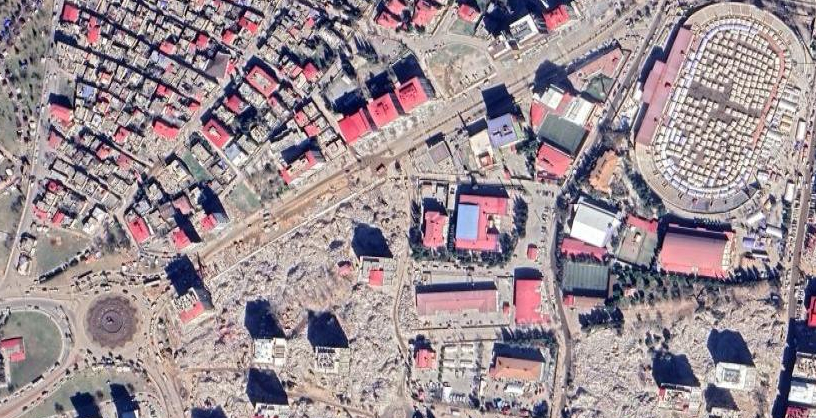
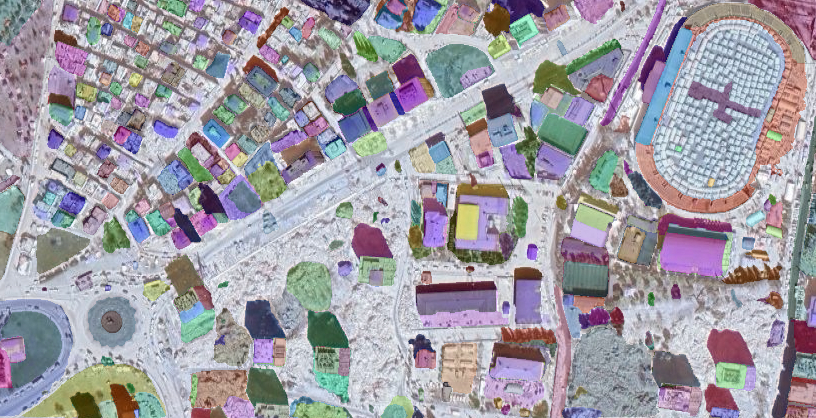

In [20]:
leafmap.image_comparison(
    "images/city.tif",
    "output/annotations2.tif",
    label1="Satellite Image",
    label2="Image Segmentation",
)

In [29]:
sam.tiff_to_shp("output/masks2.tif", "output/masks2.shp")
area2 = calc_areas("output/masks2.shp")
diff = area2-area1
print(f"area diff: {diff}")

area diff: 67356.7530776618
